In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
img_id = "CA184632V0343"
overwrite = False

output_fld = "/data_1/ATM/data_1/georef"

<h4>Check if the image is already geo-referenced</h4>

In [14]:
import pandas as pd

# define the path to processed images
csv_path = output_fld + "/sat_processed_images.csv"

# load processed images as dict
processed_images = pd.read_csv(csv_path, delimiter=";")
processed_images.set_index('id', inplace=True)
processed_images = processed_images.to_dict(orient='index')

# check if image is already geo-referenced
if processed_images.get(img_id, {}).get('status') == "georeferenced" and not overwrite:
    print(f"{img_id} already processed")
    exit()

<h4>Load Image</h4>

In [15]:
import src.load.load_image as ld

path_data_fld = "/data_1/ATM/data_1/aerial/TMA/downloaded"

# load image to geo-reference
image = ld.load_image(path_data_fld + f"/{img_id}.tif")

print(image.shape)

(9522, 10140)


<h4>Extract geo-referencing data</h4>

In [16]:
import src.base.connect_to_database as ctd
import src.base.modify_csv as mc

conn = ctd.establish_connection()

sql_string = f"SELECT * FROM images WHERE image_id='{img_id}'"
data = ctd.execute_sql(sql_string, conn)

azimuth = data.iloc[0]['azimuth']
month = data.iloc[0]['date_month']

azimuth = 360 - azimuth + 90

print("Azimuth:", azimuth)
print("Month:", month)

sql_string_approx = f"SELECT ST_AsText(footprint_approx) AS footprint_approx FROM images_extracted WHERE image_id='{img_id}'"
data_approx = ctd.execute_sql(sql_string_approx, conn)
footprint_approx = data_approx.iloc[0]['footprint_approx']

print("Approx footprint:",footprint_approx)

if footprint_approx is None:
    processed_images[img_id] = {"method": "sat", "status": "missing_data",
                                  "reason": "approx_footprint", "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
    exit()

elif azimuth is None:
    processed_images[img_id] = {"method": "sat", "status": "missing_data",
                                  "reason": "azimuth", "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
    exit()

Azimuth: 338.8565
Month: 12
Approx footprint: POLYGON((-1913454.1519969557 744664.6224907191,-1916538.7975092807 736688.6119969556,-1924514.8080030442 739773.2575092808,-1921430.1624907192 747749.2680030443,-1913454.1519969557 744664.6224907191))


<h4>Create Mask</h4>

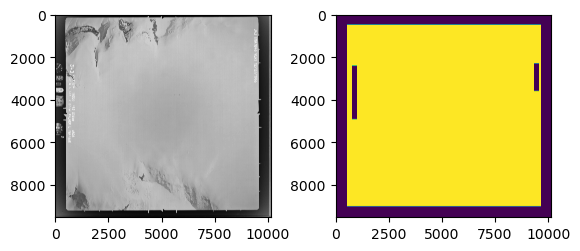

In [17]:
import src.base.create_mask as cm
import src.base.modify_csv as mc

import src.display.display_images as di

sql_string_fid_marks = f"SELECT * FROM images_fid_points WHERE image_id='{img_id}'"
data_fid_marks = ctd.execute_sql(sql_string_fid_marks, conn)

sql_string_extracted = f"SELECT * FROM images_extracted WHERE image_id='{img_id}'"
data_extracted = ctd.execute_sql(sql_string_extracted, conn)

# Get the fid marks for the specific image_id
fid_marks_row = data_fid_marks.loc[data_fid_marks['image_id'] == img_id].squeeze()

# Create fid mark dict using dictionary comprehension
fid_dict = {i: (fid_marks_row[f'fid_mark_{i}_x'], fid_marks_row[f'fid_mark_{i}_y']) for i in range(1, 5)}

# get the text boxes of the image
text_string = data_extracted.loc[data_extracted['image_id'] == img_id]['text_bbox'].iloc[0]

if len(text_string) > 0 and "[" not in text_string:
    text_string = "[" + text_string + "]"

# create text-boxes list
text_boxes = [list(group) for group in eval(text_string.replace(";", ","))]

# load the mask
mask = cm.create_mask(image, fid_dict, text_boxes)

if mask is None:
    processed_images[img_id] = {"method": "sat", "status": "missing_data",
                                  "reason": "mask", "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
    exit()


di.display_images([image, mask])

<h4>Geo-reference the image</h4>

In [18]:
import src.base.modify_csv as mc

import src.georef.georef_sat as gs

georefSat = gs.GeorefSatellite(min_tps_final=25,
                               enhance_image=False, locate_image=True, tweak_image=True, filter_outliers=True)

transform, residuals, tps, conf = georefSat.georeference(image, footprint_approx, mask, azimuth, month)

if transform is None:
    processed_images[img_id] = {"method": "sat", "status": "failed", "reason": "no_transform", "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
    exit()
else:
    print("Image successfully geo-referenced")

Geo-reference image by satellite
Adjusted image resolution with zoom-factor (0.0883, 0.0859)
Adjusted image resolution with zoom-factor (0.0883, 0.0859)
Not enough resized tie-points found (8 of 10)
Locate image position
  Check tile 1 (Coords: [-7380, -7380], Order 1)
  0 points were found in this tile.
  Check tile 2 (Coords: [-7380, 0], Order 1)
  0 points were found in this tile.
  Check tile 3 (Coords: [-7380, 7380], Order 1)
  0 points were found in this tile.
  Check tile 4 (Coords: [0, -7380], Order 1)
  11 points were found in this tile.
  Check tile 5 (Coords: [0, 7380], Order 1)
  0 points were found in this tile.
  Check tile 6 (Coords: [7380, -7380], Order 1)
  0 points were found in this tile.
  Check tile 7 (Coords: [7380, 0], Order 1)
Not enough resized tie-points found (4 of 10)
  0 points were found in this tile.
  Check tile 8 (Coords: [7380, 7380], Order 1)
  0 points were found in this tile.
  Check tile 9 (Coords: [-14760, -14760], Order 2)
  0 points were found i

<h4>Verify the image geometry</h4>

In [1]:
import src.base.modify_csv as mc
import src.georef.snippets.verify_image_geometry as vig

transform = transform.flatten()

valid_geometry, reason = vig.verify_image_geometry(image, transform)

if valid_geometry:
    print("Valid geometry:", valid_geometry)
    processed_images[img_id] = {"method": "sat", "status": "georeferenced",
                                "reason": "", "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
else:
    print("Invalid because of:", reason)
    processed_images[img_id] = {"method": "sat", "status": "invalid",
                                "reason": reason, "time":""}
    mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
    exit()

NameError: name 'transform' is not defined

<h4>Save the data </h4>

In [ ]:
import numpy as np
import pandas as pd

import src.georef.snippets.apply_transform as af
import src.georef.snippets.convert_image_to_footprint as citf

import src.export.export_geometry as eg

# merge tps and conf
tps_conf = np.concatenate([tps, conf.reshape(-1, 1), residuals.reshape((-1, 1))], axis=1)

# define path to shape file
path_shp_file = f"{output_fld}/sat.shp"

# apply the transform and save geo-referenced tiff
af.apply_transform(image, transform, f"{output_fld}/sat/{img_id}.tif")

# save transform and points
np.savetxt(f"{output_fld}/sat/{img_id}_transform.txt", transform.reshape(3,3), fmt='%.5f')
np.savetxt(f"{output_fld}/sat/{img_id}_points.txt", tps_conf, fmt=['%i', '%i', '%.2f', '%.2f', '%.3f', '%.3f'])

# create a footprint for this image
footprint = citf.convert_image_to_footprint(image, transform)

# calculate average values
# noinspection PyTypeChecker
conf_mean: float = np.mean(conf)
# noinspection PyTypeChecker
residuals_mean: float = np.mean(residuals)

# define attributes
attributes = {
    'image_id': img_id,
    'month': month,
    'num_tps': tps.shape[0],
    'avg_conf': round(conf_mean, 3),
    'avg_resi': round(residuals_mean, 3),
}

attributes = pd.DataFrame.from_dict(attributes, orient='index').T

# save footprint to shp file
eg.export_geometry(footprint, path_shp_file,
                   attributes=attributes, key_field="image_id",
                   overwrite_file=False,
                   overwrite_entry=True, attach=True)

print(f"{img_id} successfully saved")